In [1]:
import matplotlib as mplot
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D, axes3d

from math import floor

from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [2]:
T = 86400 * 29
Nt = 100
dt = T/Nt # 2.506 * 10**4

X = 1000
Nx = 30
dx = X/Nx # 33.333

Y = 1000
Ny = 30
dy = Y/Ny # 33.333

mu = 0.005
B_k = 5 * 10**(-10)

### Граничные условия
Распределение давления в начальный момент соответствует невозмущённому пласту с давлением 20 МПа, в котором находится скважина с заданным забойным давлением в 15 МПа. Скважина распологается в середине расчётной области.

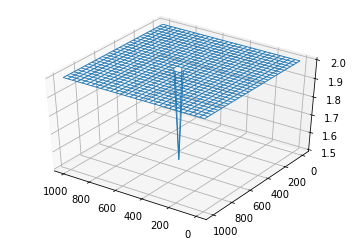

In [3]:
P_pl = 2 * 10**7

x_init = np.linspace(0, X, Nx)
y_init = np.linspace(0, Y, Ny)

X_init, Y_init = np.meshgrid(y_init, x_init)

M = np.zeros((Nx, Ny))


for i in range(0, Nx):
    for j in range(0, Ny):
        M[i,j] = P_pl

M[int(Nx/2), int(Ny/2)] =  15 * 10**6
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_wireframe(X_init, Y_init, M, linewidth=.9)
ax.view_init(40, 125)
plt.show()

In [4]:

print(X_init.shape)
# ax = 

(30, 30)


Переходим к проницаемости. Проницаемость разная во всех узлах, поэтому нужно будет создать матрицу для значений каждой ячейки. Распределение проницаемости должно описываться какой-либо функцией, при этом  задаём непроницаемую перемычку в точках x=X/3,y (10 узел по x-направлению):

In [5]:
M_perm = np.zeros((Nx, Ny))

for i in range(0, Nx-1):
    for j in range(0, Ny-1):
        if (i == 10):
            M_perm[i,j] = 10**(-20)
        else:
            M_perm[i,j] = (j * Nx + i + 1) * 10**(-15)

# pd.DataFrame(M_porosity)

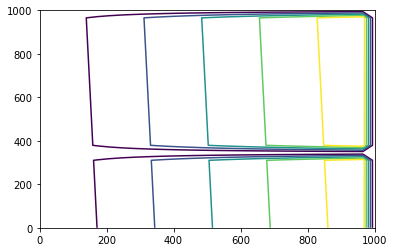

In [6]:
X_por, Y_por = np.meshgrid(np.linspace(0, Y, Ny), np.linspace(0, X, Nx))
fig = plt.figure()
plt.contour(X_por, Y_por, M_perm)
plt.show()

In [7]:
xw = X/2
yw = Y/2
N = Nx * Ny # общее количество узлов
Nw = Nx * Ny/2 + Nx/2 # порядковый узел со скважиной

Далее наша задача создать пятидиагональную матрицу для решения СЛАУ и вектор начального распределения давления на нулевом временном слое в виде сквозной нумерации узлов.

In [8]:
A = np.zeros((N, N))

def calc_permeability(i):
    k_arr = np.zeros(4)
    k_arr[0] = (2*M_perm[(i % Nx) + 1, floor(i/Nx)] * M_perm[(i%Nx), floor(i/Nx)])/ (M_perm[(i % Nx) + 1, floor(i/Nx)] + M_perm[(i%Nx), floor(i/Nx)])
    k_arr[1] = (2*M_perm[(i % Nx), floor(i/Nx)] * M_perm[(i%Nx)-1, floor(i/Nx)])/(M_perm[(i % Nx), floor(i/Nx)] + M_perm[(i%Nx)-1, floor(i/Nx)])
    k_arr[2] = (2*M_perm[(i % Nx), floor(i/Nx)+1] * M_perm[(i%Nx), floor(i/Nx)])/(M_perm[(i % Nx), floor(i/Nx)+1] + M_perm[(i%Nx), floor(i/Nx)])
    k_arr[3] = (2*M_perm[(i % Nx), floor(i/Nx)] * M_perm[(i%Nx), floor(i/Nx)-1]) / (M_perm[(i % Nx), floor(i/Nx)] + M_perm[(i%Nx), floor(i/Nx)-1])
    return k_arr

for i in range(0, N):
    if ( ( Nx < i < N-Nx ) and (( i % Nx != 0) and ( i % Nx != Nx-1)) and (i != Nw)):
        k = calc_permeability(i)
        A[i, i] = 1 + ( (dt/(mu*B_k)) * ( ((k[0]+k[1])/dx**2) + ((k[2]+k[3])/dy**2) ) )
        A[i, i+1] = - (dt*k[0]) / (mu*B_k*dx**2)
        A[i, i-1] = - (dt*k[1]) / (mu*B_k*dx**2)
        A[i, i+Nx] = - (dt*k[2]) / (mu*B_k*dx**2)
        A[i, i-Nx] = - (dt*k[3]) / (mu*B_k*dx**2)
    else:
        A[i,i] = 1



In [9]:
# print(A[464,463], A[464,464], A[464,465])
print(A[465,464], A[465,465], A[465,466])
presentation = pd.DataFrame(A[463:468,458:470])
presentation = presentation.applymap(lambda x: "{:1.3f}".format(x))
presentation

0.0 1.0 0.0


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000,0.000,0.000,0.000,-4.181,17.733,-4.190,0.000,0.000,0.000,0.000,0.000
1,0.000,0.000,0.000,0.000,0.000,-4.190,17.769,-4.199,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-4.208,17.841,-4.217,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-4.217,17.877,-4.226,0.000


После формирования пятидиагональной матрицы, переходим к расчёту по неявной разностной схеме.

In [10]:
B = np.zeros((N, 1))
print(B.shape)
# a matrix vector that contains initial P values
k = 0
for i in range(0, Nx):
    for j in range(0, Ny):
        B[k, 0] = M[i,j]
        k += 1

(900, 1)


In [11]:
P = np.zeros((Nt, Nx, Ny))
B_temp = np.copy(B)
m = np.zeros((Nx, Ny))

for t in range(1, Nt):
    B_ans = np.linalg.solve(A, B_temp)
    k = 0
    for i in range(0, Nx):
        for j in range(0, Ny):
            m[i,j] = B_ans[k]
            k += 1
    P[t] = m
    B_temp = B_ans

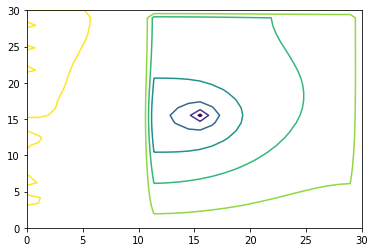

In [13]:
fig = plt.figure()
# ax = fig.gca(projection='3d')
X, Y = np.meshgrid(np.linspace(0, Ny, Ny), np.linspace(0, Nx, Nx))

plt.contour(X, Y, P[30])

# ax.plot_wireframe(X, Y, P[3])
# ax.view_init(290, 90)
plt.show()